In [317]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys, os
import pandas as pd
from pandas import DataFrame
import datetime
import numpy as np 
import scipy as sc
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold,cross_val_score, learning_curve, cross_validate,train_test_split,GridSearchCV 
from sklearn.feature_selection import RFE, RFECV 
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
import itertools

In [318]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Columns: 129 entries, AF5 to HGS10w
dtypes: float64(122), int64(2), object(5)
memory usage: 4.5+ MB


In [3]:
def ent(data):
    p_data= data.value_counts()/len(data)
    entropy=sc.stats.entropy(p_data)
    return entropy

for column in list(df.columns.values):
    print (column+':')
    print (ent(df[column]))

AF5:
5.519485860698547
AGD10:
2.727213884228698
AGD20:
3.012539158417561
AGD30:
3.1447134046565113
AGD38:
3.1690970914430445
AGD5:
2.389126368353644
AGL10:
2.6163332144363025
AGL20:
3.0280281104520994
AGL30:
3.230091473812765
AGL38:
3.276989799028176
AGL5:
2.2373595381062934
AGS10:
2.663236778567315
AGS20:
3.071922448360029
AGS30:
3.2578763004357225
AGS38:
3.299482758331971
AGS5:
2.2763915612192425
ALF5:
1.828169151862762
ALM1:
1.0802761248911847
ALM2:
1.0957334799392542
ALM3:
1.097904449902798
ALM4:
1.0985186226621377
ALM5:
1.0979107913570179
AP10:
3.2012447055677438
AP20:
3.798444246636535
AP30:
4.0774365027630095
AP38:
4.140764456689926
AP5:
2.6047434517098385
AwayTeam:
3.4432972379823243
DP10:
3.3459008882882753
DP20:
3.77402349383147
DP30:
3.9514572754743518
DP38:
3.984147184573459
DP5:
2.907663560017719
Day:
3.415643254166155
FTR:
1.0623297190258203
GD10:
2.965880054161567
GD20:
3.2746476640885325
GD30:
3.40262886967229
GD38:
3.423373326169088
GD5:
2.645886158432404
HF5:
5.521506

In [319]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    teams_code = team_code.copy()
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)
    
    form_code = df.HF5.unique()
    form_code2 = df.AF5.unique()
    form_code = np.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF5'] = to_code['HF5']
    df['AF5'] = to_code['AF5']

    return df,teams_code

df,teams_code = code_string_values(df)

In [320]:
df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

print('Zbior treningowy')
print('Udzial wygranych gospodarzy: {:.3f}'.format(y_train.value_counts()['H']/len(y_train)))
print('Udzial remisow: {:.3f}'.format(y_train.value_counts()['D']/len(y_train)))
print('Udzial wygranych gosci: {:.3f}'.format(y_train.value_counts()['A']/len(y_train)))
print()
print('Zbior walidacyjny')
print('Udzial wygranych gospodarzy: {:.3f}'.format(y_validation.value_counts()['H']/len(y_validation)))
print('Udzial remisow: {:.3f}'.format(y_validation.value_counts()['D']/len(y_validation)))
print('Udzial wygranych gosci: {:.3f}'.format(y_validation.value_counts()['A']/len(y_validation)))

Zbior treningowy
Udzial wygranych gospodarzy: 0.463
Udzial remisow: 0.255
Udzial wygranych gosci: 0.282

Zbior walidacyjny
Udzial wygranych gospodarzy: 0.455
Udzial remisow: 0.261
Udzial wygranych gosci: 0.284


In [321]:
classifier = LogisticRegression() 
classifier = classifier.fit(X_train,y_train)
print('Dokładność algorytmu regresji logistycznej na zbiorze walidacyjnym: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))

Dokładność algorytmu regresji logistycznej na zbiorze walidacyjnym: 0.508


In [322]:
X = X_train.copy()
y = y_train.copy()

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+": średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

ytest = DataFrame(y_validation)
ytrain = DataFrame(y_train)

for i in range(10):
    print('Numer podziału ',i)
    print('Dokładność na zbiorze testowym: {:.2f}'.format(scores['test_score'][i]))

LogisticRegression: średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.519
Numer podziału  0
Dokładność na zbiorze testowym: 0.52
Numer podziału  1
Dokładność na zbiorze testowym: 0.47
Numer podziału  2
Dokładność na zbiorze testowym: 0.54
Numer podziału  3
Dokładność na zbiorze testowym: 0.54
Numer podziału  4
Dokładność na zbiorze testowym: 0.52
Numer podziału  5
Dokładność na zbiorze testowym: 0.51
Numer podziału  6
Dokładność na zbiorze testowym: 0.50
Numer podziału  7
Dokładność na zbiorze testowym: 0.57
Numer podziału  8
Dokładność na zbiorze testowym: 0.55
Numer podziału  9
Dokładność na zbiorze testowym: 0.48


In [323]:
def normalize(df):
    colums_to_normalization = list(df.columns.values)
    df[colums_to_normalization] = df[colums_to_normalization].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    return df

In [11]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+" średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

LogisticRegression średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.524


In [12]:
for j in range(5):
    for i in range(2):
        X = X_train.copy()
        y = y_train.copy()
        if i == 1:
            X = normalize(X)
            print("Po normalizacji :")
        else :
            print("Przed normalizacją :")

        classifier = LogisticRegression()
        scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', n_jobs=-1)
        print("Średni czas uczenia %2.3f" % scores['fit_time'].mean())
    print('\n')

Przed normalizacją :
Średni czas uczenia 7.540
Po normalizacji :
Średni czas uczenia 1.402


Przed normalizacją :
Średni czas uczenia 7.228
Po normalizacji :
Średni czas uczenia 1.406


Przed normalizacją :
Średni czas uczenia 7.102
Po normalizacji :
Średni czas uczenia 1.280


Przed normalizacją :
Średni czas uczenia 6.784
Po normalizacji :
Średni czas uczenia 1.464


Przed normalizacją :
Średni czas uczenia 7.076
Po normalizacji :
Średni czas uczenia 1.358




Optimal liczba zmiennych: 9
Wybrane zmienne: ['DP10', 'DP10w', 'DP30w', 'DP38', 'DP38w', 'DP5w', 'DPB30', 'GD10w', 'LSTPD']


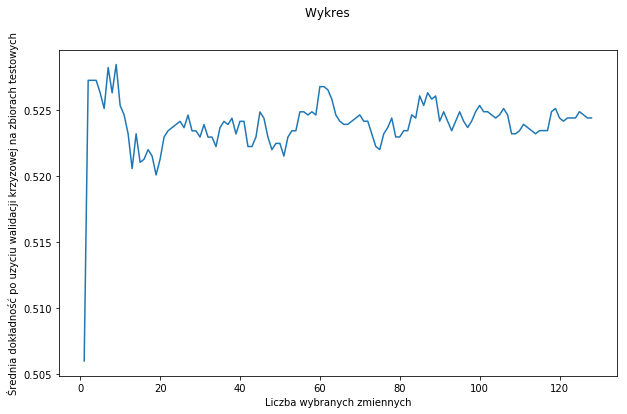

LogisticRegression: średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.528


In [324]:
X = X_train.copy()
y = y_train.copy()
X = normalize(X)

rfecv = RFECV(estimator=LogisticRegression(), cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal liczba zmiennych: %d" % rfecv.n_features_)
print('Wybrane zmienne: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

plt.figure(figsize=(10,6))
plt.suptitle('Wykres ')
plt.xlabel("Liczba wybranych zmiennych")
plt.ylabel("Średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+": średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

In [14]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

#Poniewaz niektore kombinacje parametrow sa niedozwolone nalezy utworzyc kilka słowników
param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
   'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
   'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=10)
model_lr.fit(X, y)
clf = model_lr.best_estimator_
print('Najlepszy estymator i jego parametry:')
print (model_lr.best_score_, model_lr.best_params_) 

Najlepszy estymator i jego parametry:
0.5311004784688995 {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


In [44]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

classifier = LogisticRegression(C= 10,penalty= 'l1',class_weight= None,solver= 'saga') 
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+": średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

LogisticRegression: średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.531


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

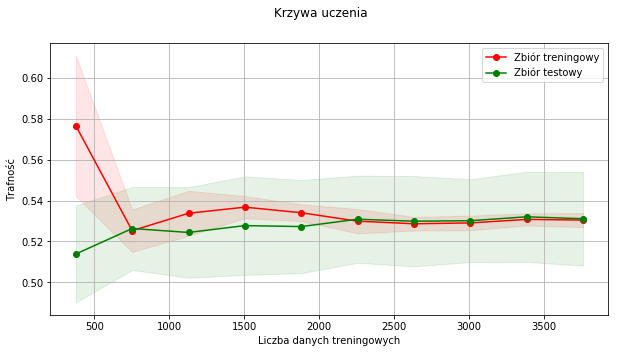

In [49]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.suptitle('Krzywa uczenia')
    plt.xlabel("Liczba danych treningowych")
    plt.ylabel("Trafność")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Zbiór treningowy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Zbiór testowy")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve(LogisticRegression(C= 10,penalty= 'l1',class_weight= None,solver= 'saga')  , X, y )

In [325]:
df_copy = df.copy()

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = normalize(df_copy[df_copy.columns.difference(['FTR'])])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

In [326]:
classifier = LogisticRegression(C= 10,penalty= 'l1',class_weight= None,solver= 'saga') 
classifier = classifier.fit(X_train,y_train)
print('Dokładność algorytmu regresji logistycznej na zbiorze walidacyjnym: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Dokładność algorytmu regresji logistycznej na zbiorze treningowym: {:.3f}'.format(classifier.score(X_train, y_train)))

scores = cross_validate(classifier, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+": średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

y_pred = classifier.predict(X_validation)
print('\n','Macierz pomyłek: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Raport klasyfikacji: ')
print(classification_report(y_validation, y_pred))

Dokładność algorytmu regresji logistycznej na zbiorze walidacyjnym: 0.539
Dokładność algorytmu regresji logistycznej na zbiorze treningowym: 0.531
LogisticRegression: średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.531

 Macierz pomyłek: 
[[ 55   2  51]
 [ 28   2  69]
 [ 25   0 148]] 

Raport klasyfikacji: 
              precision    recall  f1-score   support

           A       0.51      0.51      0.51       108
           D       0.50      0.02      0.04        99
           H       0.55      0.86      0.67       173

   micro avg       0.54      0.54      0.54       380
   macro avg       0.52      0.46      0.41       380
weighted avg       0.53      0.54      0.46       380



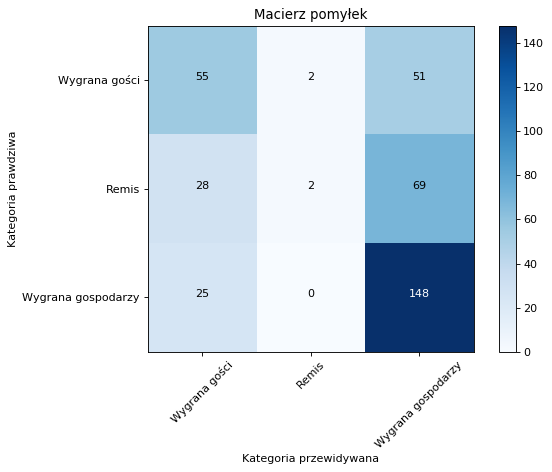

In [328]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Kategoria prawdziwa')
    plt.xlabel('Kategoria przewidywana')
    plt.tight_layout()


cnf_matrix = confusion_matrix(y_validation, y_pred)
np.set_printoptions(precision=2)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes= ['Wygrana gości', 'Remis', 'Wygrana gospodarzy'],
                      title='Macierz pomyłek')
plt.show()

In [48]:
#### XGBOOST

In [310]:
df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

In [113]:
classifier = xgb.XGBClassifier(nthread =-1)
classifier.fit(X_train, y_train)
print('Dokładność algorytmu XGBoost na zbiorze walidacyjnym: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))

Dokładność algorytmu XGBoost na zbiorze walidacyjnym: 0.547


[0]	validation_0-merror:0.455263	validation_1-merror:0.463158
[1]	validation_0-merror:0.455263	validation_1-merror:0.463158
[2]	validation_0-merror:0.456459	validation_1-merror:0.460526
[3]	validation_0-merror:0.456938	validation_1-merror:0.463158
[4]	validation_0-merror:0.452632	validation_1-merror:0.455263
[5]	validation_0-merror:0.452392	validation_1-merror:0.460526
[6]	validation_0-merror:0.450718	validation_1-merror:0.468421
[7]	validation_0-merror:0.449761	validation_1-merror:0.473684
[8]	validation_0-merror:0.447608	validation_1-merror:0.471053
[9]	validation_0-merror:0.447129	validation_1-merror:0.473684
[10]	validation_0-merror:0.447847	validation_1-merror:0.473684
[11]	validation_0-merror:0.446651	validation_1-merror:0.463158
[12]	validation_0-merror:0.446172	validation_1-merror:0.465789
[13]	validation_0-merror:0.445933	validation_1-merror:0.463158
[14]	validation_0-merror:0.44378	validation_1-merror:0.463158
[15]	validation_0-merror:0.44378	validation_1-merror:0.463158
[16]

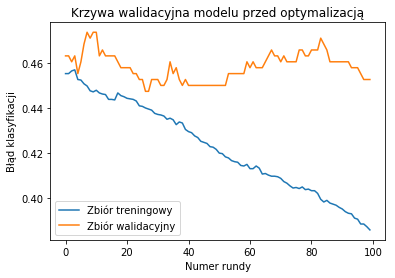

In [116]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Zbiór treningowy')
ax.plot(x_axis, results['validation_1']['merror'], label='Zbiór walidacyjny')
ax.legend()
plt.ylabel('Błąd klasyfikacji')
plt.xlabel('Numer rundy')
plt.title('Krzywa walidacyjna modelu przed optymalizacją')
plt.show()

In [51]:
X = X_train.copy()
y = y_train.copy()

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+": średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

ytest = DataFrame(y_validation)
ytrain = DataFrame(y_train)

for i in range(10):
    print('Numer podziału ',i)
    print('Dokładność na zbiorze testowym: {:.2f}'.format(scores['test_score'][i]))

XGBClassifier: średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.524
Numer podziału  0
Dokładność na zbiorze testowym: 0.55
Numer podziału  1
Dokładność na zbiorze testowym: 0.49
Numer podziału  2
Dokładność na zbiorze testowym: 0.53
Numer podziału  3
Dokładność na zbiorze testowym: 0.54
Numer podziału  4
Dokładność na zbiorze testowym: 0.51
Numer podziału  5
Dokładność na zbiorze testowym: 0.51
Numer podziału  6
Dokładność na zbiorze testowym: 0.52
Numer podziału  7
Dokładność na zbiorze testowym: 0.56
Numer podziału  8
Dokładność na zbiorze testowym: 0.54
Numer podziału  9
Dokładność na zbiorze testowym: 0.49


In [52]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

model = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+" średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

XGBClassifier średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.524


In [53]:
for j in range(5):
    for i in range(2):
        X = X_train.copy()
        y = y_train.copy()
        if i == 1:
            X = normalize(X)
            print("Po normalizacji :")
        else :
            print("Przed normalizacja :")

        classifier = xgb.XGBClassifier(nthread =-1)
        scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', n_jobs=-1)
        print("Średni czas uczenia %2.3f" % scores['fit_time'].mean())
    print('\n')

Przed normalizacja :
Średni czas uczenia 6.878
Po normalizacji :
Średni czas uczenia 6.826


Przed normalizacja :
Średni czas uczenia 6.469
Po normalizacji :
Średni czas uczenia 6.379


Przed normalizacja :
Średni czas uczenia 6.602
Po normalizacji :
Średni czas uczenia 7.194


Przed normalizacja :
Średni czas uczenia 7.107
Po normalizacji :
Średni czas uczenia 7.085


Przed normalizacja :
Średni czas uczenia 7.315
Po normalizacji :
Średni czas uczenia 7.568




Optimal liczba zmiennych: 40
Wybrane zmienne: ['AF5', 'AGD30', 'AGD5w', 'AGL10w', 'AGL30w', 'AGL5w', 'AGS10w', 'AGS20', 'AGS20w', 'AP10w', 'AP30w', 'AP38w', 'AP5w', 'AwayTeam', 'DP10w', 'DP20', 'DP20w', 'DP30w', 'DP38', 'DP5w', 'DPB10', 'DPB5', 'GD20w', 'GD30w', 'GD5', 'HF5', 'HGD20w', 'HGD30w', 'HGD5', 'HGL10w', 'HGL5w', 'HGS38w', 'HLF5', 'HP10', 'HP30w', 'HP5w', 'HomeTeam', 'LSTPA', 'LSTPD', 'LSTPH']


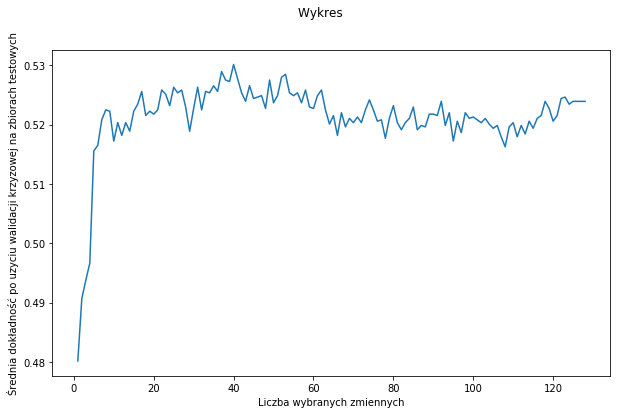

XGBClassifier średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.530


In [311]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal liczba zmiennych: %d" % rfecv.n_features_)
print('Wybrane zmienne: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

plt.figure(figsize=(10,6))
plt.suptitle('Wykres ')
plt.xlabel("Liczba wybranych zmiennych")
plt.ylabel("Średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

[0]	validation_0-merror:0.457416	validation_1-merror:0.463158
[1]	validation_0-merror:0.456938	validation_1-merror:0.463158
[2]	validation_0-merror:0.456938	validation_1-merror:0.463158
[3]	validation_0-merror:0.452871	validation_1-merror:0.476316
[4]	validation_0-merror:0.451435	validation_1-merror:0.486842
[5]	validation_0-merror:0.450957	validation_1-merror:0.481579
[6]	validation_0-merror:0.449043	validation_1-merror:0.478947
[7]	validation_0-merror:0.449282	validation_1-merror:0.476316
[8]	validation_0-merror:0.447368	validation_1-merror:0.478947
[9]	validation_0-merror:0.447368	validation_1-merror:0.476316
[10]	validation_0-merror:0.447129	validation_1-merror:0.473684
[11]	validation_0-merror:0.446651	validation_1-merror:0.473684
[12]	validation_0-merror:0.444976	validation_1-merror:0.465789
[13]	validation_0-merror:0.445455	validation_1-merror:0.468421
[14]	validation_0-merror:0.445694	validation_1-merror:0.471053
[15]	validation_0-merror:0.446172	validation_1-merror:0.460526
[1

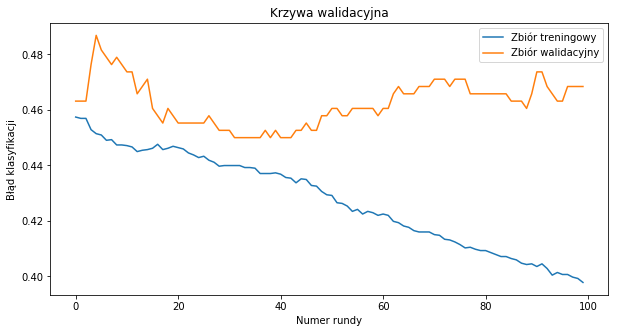

In [86]:
df_copy = df.copy()

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]


unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Zbiór treningowy')
ax.plot(x_axis, results['validation_1']['merror'], label='Zbiór walidacyjny')
ax.legend()
plt.ylabel('Błąd klasyfikacji')
plt.xlabel('Numer rundy')
plt.title('Krzywa walidacyjna')
plt.show()

In [37]:
df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']


X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(nthread =-1)
fit_params={'early_stopping_rounds': 30, 
            'verbose': 10,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.530


In [25]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [26]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]


parameters = {  
    "min_child_weight": st.randint(0, 20),
    "gamma": st.randint(0, 10),
    "subsample": st.beta(10, 1),
    "colsample_bytree": st.beta(10, 1),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.01, 0.1)
}

fit_params={'early_stopping_rounds': 30, 
            'eval_set': [[X, y]]}


classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    gs = RandomizedSearchCV(classifier,param_distributions =parameters,fit_params=fit_params,cv=10,n_jobs=-1,n_iter=200, verbose=10) 
    gs.fit(X, y)  
    
print (gs.best_score_, gs.best_params_) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

0.5382775119617225 {'colsample_bytree': 0.7339742633884566, 'gamma': 9, 'learning_rate': 0.013891168877230289, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9621297673898643}


In [41]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9621297673898643, gamma= 9, min_child_weight= 5, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

fit_params={'early_stopping_rounds': 30, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.538


In [312]:
df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

In [313]:
classifier = xgb.XGBClassifier(subsample=0.9221297673898643, gamma= 9, min_child_weight= 9, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 30,verbose= True,eval_set= [[X_validation, y_validation]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.457895
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.465789
[2]	validation_0-merror:0.465789
[3]	validation_0-merror:0.468421
[4]	validation_0-merror:0.457895
[5]	validation_0-merror:0.455263
[6]	validation_0-merror:0.460526
[7]	validation_0-merror:0.463158
[8]	validation_0-merror:0.471053
[9]	validation_0-merror:0.468421
[10]	validation_0-merror:0.465789
[11]	validation_0-merror:0.468421
[12]	validation_0-merror:0.465789
[13]	validation_0-merror:0.468421
[14]	validation_0-merror:0.468421
[15]	validation_0-merror:0.468421
[16]	validation_0-merror:0.468421
[17]	validation_0-merror:0.465789
[18]	validation_0-merror:0.465789
[19]	validation_0-merror:0.465789
[20]	validation_0-merror:0.465789
[21]	validation_0-merror:0.465789
[22]	validation_0-merror:0.468421
[23]	validation_0-merror:0.468421
[24]	validation_0-merror:0.468421
[25]	validation_0-merror:0.468421
[26]	validation_0-merror:0.468421
[27]	validation_0-merror:

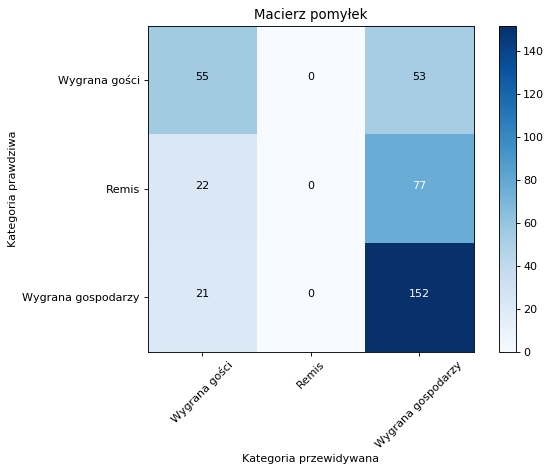

In [315]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Kategoria prawdziwa')
    plt.xlabel('Kategoria przewidywana')
    plt.tight_layout()


cnf_matrix = confusion_matrix(y_validation, y_pred)
np.set_printoptions(precision=2)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes= ['Wygrana gości', 'Remis', 'Wygrana gospodarzy'],
                      title='Macierz pomyłek')
plt.show()

[0]	validation_0-merror:0.458612	validation_1-merror:0.457895
[1]	validation_0-merror:0.461483	validation_1-merror:0.465789
[2]	validation_0-merror:0.459091	validation_1-merror:0.473684
[3]	validation_0-merror:0.458134	validation_1-merror:0.473684
[4]	validation_0-merror:0.458852	validation_1-merror:0.457895
[5]	validation_0-merror:0.455981	validation_1-merror:0.455263
[6]	validation_0-merror:0.458852	validation_1-merror:0.460526
[7]	validation_0-merror:0.458852	validation_1-merror:0.463158
[8]	validation_0-merror:0.457416	validation_1-merror:0.471053
[9]	validation_0-merror:0.457177	validation_1-merror:0.468421
[10]	validation_0-merror:0.45622	validation_1-merror:0.465789
[11]	validation_0-merror:0.456699	validation_1-merror:0.468421
[12]	validation_0-merror:0.45622	validation_1-merror:0.471053
[13]	validation_0-merror:0.458373	validation_1-merror:0.471053
[14]	validation_0-merror:0.459091	validation_1-merror:0.468421
[15]	validation_0-merror:0.458612	validation_1-merror:0.468421
[16]

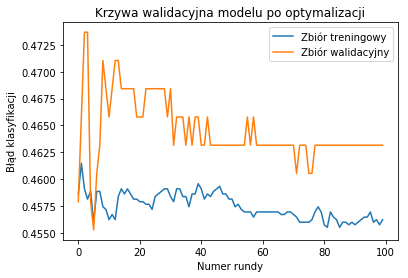

In [122]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(n_estimators=100,subsample=0.9221297673898643, gamma= 9, min_child_weight= 5, 
                               colsample_bytree=0.7339742633884566, max_depth= 6,learning_rate=0.013891168877230289,nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Zbiór treningowy')
ax.plot(x_axis, results['validation_1']['merror'], label='Zbiór walidacyjny')
ax.legend()
plt.ylabel('Błąd klasyfikacji')
plt.xlabel('Numer rundy')
plt.title('Krzywa walidacyjna modelu po optymalizacji')
plt.show()

In [ ]:
#Szukanie danych generujących błędy klasyfikacji

[0]	validation_0-merror:0.458612
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.461483
[2]	validation_0-merror:0.460766
[3]	validation_0-merror:0.458612
[4]	validation_0-merror:0.458852
[5]	validation_0-merror:0.456699
[6]	validation_0-merror:0.458612
[7]	validation_0-merror:0.458612
[8]	validation_0-merror:0.457655
[9]	validation_0-merror:0.457655
[10]	validation_0-merror:0.457416
[11]	validation_0-merror:0.457416
[12]	validation_0-merror:0.457177
[13]	validation_0-merror:0.458134
[14]	validation_0-merror:0.458134
[15]	validation_0-merror:0.459091
Stopping. Best iteration:
[5]	validation_0-merror:0.456699



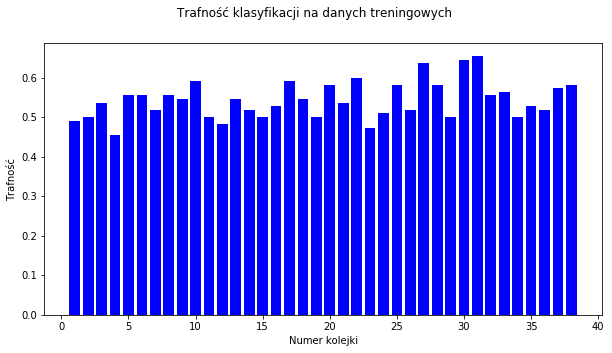

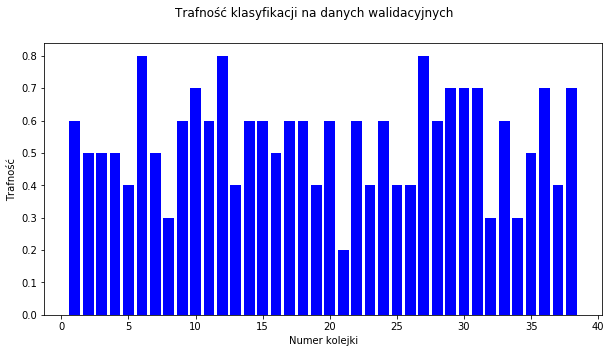

In [136]:
df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9221297673898643, gamma= 9, min_child_weight= 9, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_copy1[df_copy1.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Trafność klasyfikacji na danych treningowych')
plt.xlabel('Numer kolejki')
plt.ylabel('Trafność')
plt.show()
    
weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_test[df_test.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Trafność klasyfikacji na danych walidacyjnych')
plt.xlabel('Numer kolejki')
plt.ylabel('Trafność')
plt.show()

In [137]:
df_copy = df.copy()
df_copy = df_copy[df_copy.MW >4]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9221297673898643, gamma= 9, min_child_weight= 9, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 30,verbose= True,eval_set= [[X_validation, y_validation]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.485294
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.467647
[2]	validation_0-merror:0.464706
[3]	validation_0-merror:0.464706
[4]	validation_0-merror:0.470588
[5]	validation_0-merror:0.464706
[6]	validation_0-merror:0.467647
[7]	validation_0-merror:0.461765
[8]	validation_0-merror:0.458824
[9]	validation_0-merror:0.461765
[10]	validation_0-merror:0.461765
[11]	validation_0-merror:0.461765
[12]	validation_0-merror:0.461765
[13]	validation_0-merror:0.464706
[14]	validation_0-merror:0.464706
[15]	validation_0-merror:0.458824
[16]	validation_0-merror:0.461765
[17]	validation_0-merror:0.455882
[18]	validation_0-merror:0.45
[19]	validation_0-merror:0.45
[20]	validation_0-merror:0.452941
[21]	validation_0-merror:0.452941
[22]	validation_0-merror:0.455882
[23]	validation_0-merror:0.455882
[24]	validation_0-merror:0.452941
[25]	validation_0-merror:0.447059
[26]	validation_0-merror:0.447059
[27]	validation_0-merror:0.45
[28

[0]	validation_0-merror:0.458612
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.461483
[2]	validation_0-merror:0.460766
[3]	validation_0-merror:0.458612
[4]	validation_0-merror:0.458852
[5]	validation_0-merror:0.456699
[6]	validation_0-merror:0.458612
[7]	validation_0-merror:0.458612
[8]	validation_0-merror:0.457655
[9]	validation_0-merror:0.457655
[10]	validation_0-merror:0.457416
[11]	validation_0-merror:0.457416
[12]	validation_0-merror:0.457177
[13]	validation_0-merror:0.458134
[14]	validation_0-merror:0.458134
[15]	validation_0-merror:0.459091
Stopping. Best iteration:
[5]	validation_0-merror:0.456699



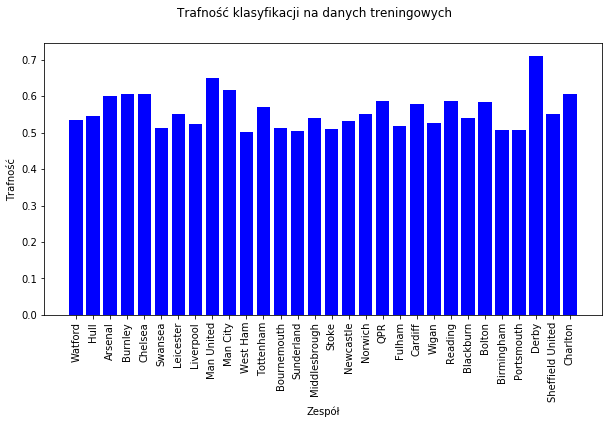

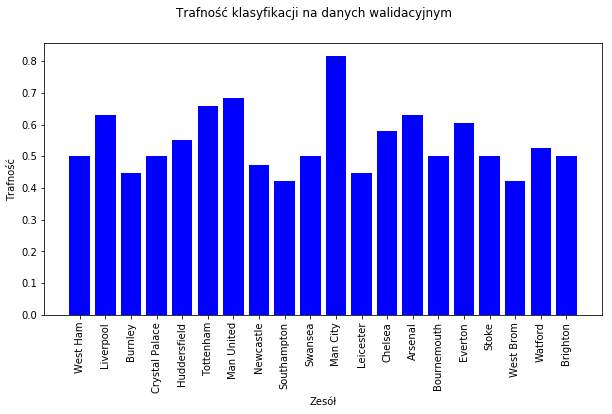

In [157]:
def find_team(team_code):
    for k, v in teams_code.items():
        if v == team_code:
            return k
    return None


df_copy = df.copy()
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9221297673898643, gamma= 9, min_child_weight= 9, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_copy1['HomeTeam']):
    df_test1 = df_copy1[(df_copy1.HomeTeam == team) | (df_copy1.AwayTeam == team)]
    
    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.5:
        teams_with_high_accuracy.append(team)
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Trafność klasyfikacji na danych treningowych')
plt.xlabel('Zespół')
plt.ylabel('Trafność')
plt.show()

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
#     if classifier.score(X_validation, y_validation) > 0.5:
#         teams_with_high_accuracy.append(team)
    weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
    idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Trafność klasyfikacji na danych walidacyjnym')
plt.xlabel('Zesół')
plt.ylabel('Trafność')
plt.show()

In [159]:
df_copy = df.copy()
df_copy = df_copy[df_copy.MW >4]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = df_copy[(df_copy.HomeTeam.isin(teams_with_high_accuracy)) | (df_copy.AwayTeam.isin(teams_with_high_accuracy))]

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

y_train = df_copy1.loc[380:]['FTR']
y_validation = df_test.loc[0:379]['FTR']

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9221297673898643, gamma= 9, min_child_weight= 9, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of XGBClassifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of XGBClassifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.461722
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.463158
[2]	validation_0-merror:0.461483
[3]	validation_0-merror:0.461483
[4]	validation_0-merror:0.461244
[5]	validation_0-merror:0.461005
[6]	validation_0-merror:0.463397
[7]	validation_0-merror:0.463636
[8]	validation_0-merror:0.463158
[9]	validation_0-merror:0.463636
[10]	validation_0-merror:0.463636
[11]	validation_0-merror:0.462919
[12]	validation_0-merror:0.464115
[13]	validation_0-merror:0.464593
[14]	validation_0-merror:0.463636
[15]	validation_0-merror:0.464593
[16]	validation_0-merror:0.464354
[17]	validation_0-merror:0.464593
[18]	validation_0-merror:0.463636
[19]	validation_0-merror:0.462919
[20]	validation_0-merror:0.463397
[21]	validation_0-merror:0.462919
[22]	validation_0-merror:0.462679
[23]	validation_0-merror:0.463876
[24]	validation_0-merror:0.463876
[25]	validation_0-merror:0.464593
Stopping. Best iteration:
[5]	validation_0-merror:0.461005


[0]	validation_0-merror:0.461722
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.463158
[2]	validation_0-merror:0.461483
[3]	validation_0-merror:0.461483
[4]	validation_0-merror:0.461244
[5]	validation_0-merror:0.461005
[6]	validation_0-merror:0.463397
[7]	validation_0-merror:0.463636
[8]	validation_0-merror:0.463158
[9]	validation_0-merror:0.463636
[10]	validation_0-merror:0.463636
[11]	validation_0-merror:0.462919
[12]	validation_0-merror:0.464115
[13]	validation_0-merror:0.464593
[14]	validation_0-merror:0.463636
[15]	validation_0-merror:0.464593
Stopping. Best iteration:
[5]	validation_0-merror:0.461005



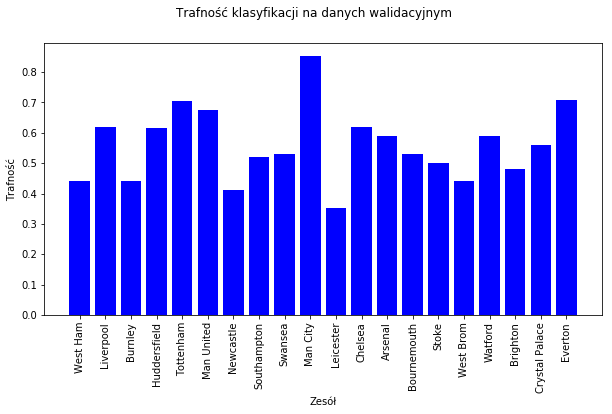

In [158]:
df_copy = df.copy()
df_copy = df_copy[df_copy.MW >4]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = df_copy[(df_copy.HomeTeam.isin(teams_with_high_accuracy)) | (df_copy.AwayTeam.isin(teams_with_high_accuracy))]

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9221297673898643, gamma= 9, min_child_weight= 9, 
                               colsample_bytree=0.7339742633884566, max_depth= 4,learning_rate=0.013891168877230289,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X, y]])

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
    idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Trafność klasyfikacji na danych walidacyjnym')
plt.xlabel('Zesół')
plt.ylabel('Trafność')
plt.show()

In [ ]:
#Klasyfikacja binarna

In [164]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

In [165]:
classifier = xgb.XGBClassifier(nthread =-1)
classifier.fit(X_train, y_train)
print('Dokładność algorytmu XGBoost na zbiorze walidacyjnym: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))

Dokładność algorytmu XGBoost na zbiorze walidacyjnym: 0.726


[0]	validation_0-error:0.294382	validation_1-error:0.27758
[1]	validation_0-error:0.29053	validation_1-error:0.274021
[2]	validation_0-error:0.273836	validation_1-error:0.270463
[3]	validation_0-error:0.273194	validation_1-error:0.274021
[4]	validation_0-error:0.275441	validation_1-error:0.270463
[5]	validation_0-error:0.264848	validation_1-error:0.274021
[6]	validation_0-error:0.265811	validation_1-error:0.27758
[7]	validation_0-error:0.260995	validation_1-error:0.274021
[8]	validation_0-error:0.264205	validation_1-error:0.27758
[9]	validation_0-error:0.264526	validation_1-error:0.270463
[10]	validation_0-error:0.263884	validation_1-error:0.274021
[11]	validation_0-error:0.262921	validation_1-error:0.266904
[12]	validation_0-error:0.261958	validation_1-error:0.266904
[13]	validation_0-error:0.260353	validation_1-error:0.266904
[14]	validation_0-error:0.260995	validation_1-error:0.270463
[15]	validation_0-error:0.262921	validation_1-error:0.281139
[16]	validation_0-error:0.262279	valid

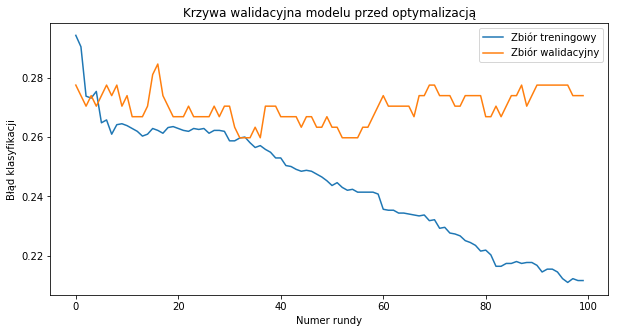

In [168]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["error"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Zbiór treningowy')
ax.plot(x_axis, results['validation_1']['error'], label='Zbiór walidacyjny')
ax.legend()
plt.ylabel('Błąd klasyfikacji')
plt.xlabel('Numer rundy')
plt.title('Krzywa walidacyjna modelu przed optymalizacją')
plt.show()

In [169]:
X = X_train.copy()
y = y_train.copy()

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+": średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

XGBClassifier: średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.703


Optimal liczba zmiennych: 104
Wybrane zmienne: ['AF5', 'AGD10', 'AGD10w', 'AGD20w', 'AGD30', 'AGD30w', 'AGD38', 'AGD5', 'AGD5w', 'AGL10', 'AGL10w', 'AGL20', 'AGL20w', 'AGL30', 'AGL30w', 'AGL38', 'AGL38w', 'AGL5w', 'AGS10', 'AGS10w', 'AGS20', 'AGS20w', 'AGS30', 'AGS30w', 'AGS38', 'AGS5', 'AGS5w', 'ALM1', 'ALM3', 'AP10', 'AP10w', 'AP20', 'AP20w', 'AP30', 'AP30w', 'AP38', 'AP38w', 'AP5', 'AP5w', 'AwayTeam', 'DP10', 'DP10w', 'DP20', 'DP20w', 'DP30', 'DP30w', 'DP38', 'DP38w', 'DP5', 'DP5w', 'DPB10', 'DPB20', 'DPB5', 'Day', 'GD10', 'GD10w', 'GD20', 'GD20w', 'GD30', 'GD30w', 'GD38w', 'GD5', 'HF5', 'HGD10', 'HGD10w', 'HGD20', 'HGD20w', 'HGD30', 'HGD30w', 'HGD5', 'HGD5w', 'HGL10', 'HGL10w', 'HGL20w', 'HGL30w', 'HGL38w', 'HGL5', 'HGL5w', 'HGS10w', 'HGS20w', 'HGS30', 'HGS38', 'HGS38w', 'HGS5w', 'HLF5', 'HLM2', 'HLM4', 'HP10', 'HP10w', 'HP20', 'HP20w', 'HP30', 'HP30w', 'HP38', 'HP38w', 'HP5w', 'HomeTeam', 'LFD5', 'LSTPA', 'LSTPD', 'LSTPH', 'MW', 'Month', 'Year']


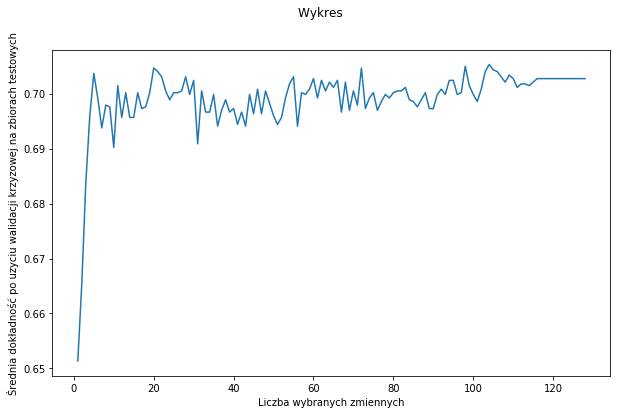

XGBClassifier średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych 0.703


In [163]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal liczba zmiennych: %d" % rfecv.n_features_)
print('Wybrane zmienne: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

plt.figure(figsize=(10,6))
plt.suptitle('Wykres ')
plt.xlabel("Liczba wybranych zmiennych")
plt.ylabel("Średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" średnia dokładność po uzyciu walidacji krzyzowej na zbiorach testowych %2.3f" % scores['test_score'].mean())

In [186]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(nthread =-1)
fit_params={'early_stopping_rounds': 10, 
            'verbose': 10,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.712


In [175]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]


parameters = {  
    "min_child_weight": st.randint(0, 20),
    "gamma": st.randint(0, 10),
    "subsample": st.beta(10, 1),
    "colsample_bytree": st.beta(10, 1),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.01, 0.1)
}

fit_params={'early_stopping_rounds': 10, 
            'eval_set': [[X, y]]}


classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    gs = RandomizedSearchCV(classifier,param_distributions =parameters,fit_params=fit_params,cv=10,n_jobs=-1,n_iter=200, verbose=10) 
    gs.fit(X, y)  
    
print (gs.best_score_, gs.best_params_) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

0.7219903691813804 {'colsample_bytree': 0.8471293784347718, 'gamma': 6, 'learning_rate': 0.03790066341815391, 'max_depth': 3, 'min_child_weight': 0, 'subsample': 0.9930997509655403}


In [187]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

fit_params={'early_stopping_rounds': 10, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.722


In [303]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]


X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

In [304]:
classifier = xgb.XGBClassifier(subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 10,verbose= True,eval_set= [[X_validation, y_validation]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-error:0.274021
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.259786
[2]	validation_0-error:0.266904
[3]	validation_0-error:0.270463
[4]	validation_0-error:0.27758
[5]	validation_0-error:0.27758
[6]	validation_0-error:0.274021
[7]	validation_0-error:0.27758
[8]	validation_0-error:0.27758
[9]	validation_0-error:0.27758
[10]	validation_0-error:0.281139
[11]	validation_0-error:0.27758
Stopping. Best iteration:
[1]	validation_0-error:0.259786

Accuracy of logistic regression classifier on test validation set: 0.740
Accuracy of logistic regression classifier on train set: 0.728

 Confusion matrix: 
[[ 58  50]
 [ 23 150]] 

Classification report: 
              precision    recall  f1-score   support

           A       0.72      0.54      0.61       108
           H       0.75      0.87      0.80       173

   micro avg       0.74      0.74      0.74       281
   macro avg       0.73      0.70      0.71       281
weighted avg     

[0]	validation_0-error:0.289888	validation_1-error:0.274021
[1]	validation_0-error:0.271589	validation_1-error:0.259786
[2]	validation_0-error:0.271589	validation_1-error:0.266904
[3]	validation_0-error:0.274157	validation_1-error:0.270463
[4]	validation_0-error:0.273836	validation_1-error:0.27758
[5]	validation_0-error:0.27512	validation_1-error:0.27758
[6]	validation_0-error:0.278331	validation_1-error:0.274021
[7]	validation_0-error:0.272552	validation_1-error:0.27758
[8]	validation_0-error:0.273515	validation_1-error:0.27758
[9]	validation_0-error:0.271589	validation_1-error:0.27758
[10]	validation_0-error:0.272231	validation_1-error:0.281139
[11]	validation_0-error:0.27191	validation_1-error:0.27758
[12]	validation_0-error:0.270947	validation_1-error:0.281139
[13]	validation_0-error:0.270305	validation_1-error:0.270463
[14]	validation_0-error:0.271589	validation_1-error:0.270463
[15]	validation_0-error:0.269663	validation_1-error:0.27758
[16]	validation_0-error:0.269984	validation

[135]	validation_0-error:0.25008	validation_1-error:0.252669
[136]	validation_0-error:0.249438	validation_1-error:0.245552
[137]	validation_0-error:0.248796	validation_1-error:0.245552
[138]	validation_0-error:0.249438	validation_1-error:0.24911
[139]	validation_0-error:0.248475	validation_1-error:0.24911
[140]	validation_0-error:0.248475	validation_1-error:0.24911
[141]	validation_0-error:0.248475	validation_1-error:0.24911
[142]	validation_0-error:0.248475	validation_1-error:0.24911
[143]	validation_0-error:0.248796	validation_1-error:0.24911
[144]	validation_0-error:0.248796	validation_1-error:0.24911
[145]	validation_0-error:0.248796	validation_1-error:0.252669
[146]	validation_0-error:0.248475	validation_1-error:0.259786
[147]	validation_0-error:0.248475	validation_1-error:0.259786
[148]	validation_0-error:0.248154	validation_1-error:0.259786
[149]	validation_0-error:0.248154	validation_1-error:0.259786


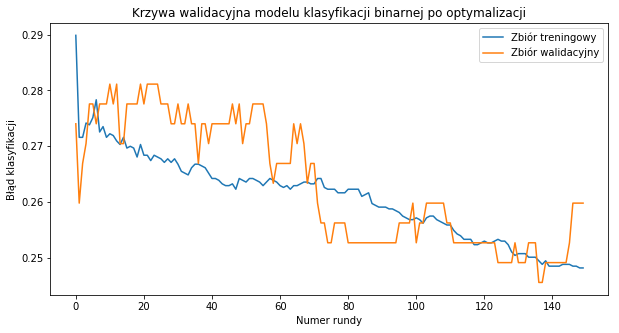

In [283]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(n_estimators=150, subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["error"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Zbiór treningowy')
ax.plot(x_axis, results['validation_1']['error'], label='Zbiór walidacyjny')
ax.legend()
plt.ylabel('Błąd klasyfikacji')
plt.xlabel('Numer rundy')
plt.title('Krzywa walidacyjna modelu klasyfikacji binarnej po optymalizacji')
plt.show()

In [305]:
classifier = xgb.XGBClassifier(n_estimators=150, subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 80,verbose= True,eval_set= [[X_validation, y_validation]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-error:0.274021
Will train until validation_0-error hasn't improved in 80 rounds.
[1]	validation_0-error:0.259786
[2]	validation_0-error:0.266904
[3]	validation_0-error:0.270463
[4]	validation_0-error:0.27758
[5]	validation_0-error:0.27758
[6]	validation_0-error:0.274021
[7]	validation_0-error:0.27758
[8]	validation_0-error:0.27758
[9]	validation_0-error:0.27758
[10]	validation_0-error:0.281139
[11]	validation_0-error:0.27758
[12]	validation_0-error:0.281139
[13]	validation_0-error:0.270463
[14]	validation_0-error:0.270463
[15]	validation_0-error:0.27758
[16]	validation_0-error:0.27758
[17]	validation_0-error:0.27758
[18]	validation_0-error:0.27758
[19]	validation_0-error:0.281139
[20]	validation_0-error:0.27758
[21]	validation_0-error:0.281139
[22]	validation_0-error:0.281139
[23]	validation_0-error:0.281139
[24]	validation_0-error:0.281139
[25]	validation_0-error:0.27758
[26]	validation_0-error:0.27758
[27]	validation_0-error:0.27758
[28]	validation_0-error:0.274021
[

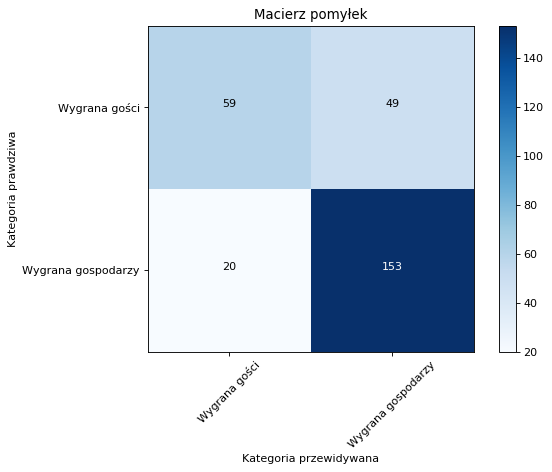

In [309]:
cnf_matrix = confusion_matrix(y_validation, y_pred)
np.set_printoptions(precision=2)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes= ['Wygrana gości', 'Wygrana gospodarzy'],
                      title='Macierz pomyłek')
plt.show()

In [ ]:
#Szukanie danych generujacych błędy dla klasyfikacji binarnej

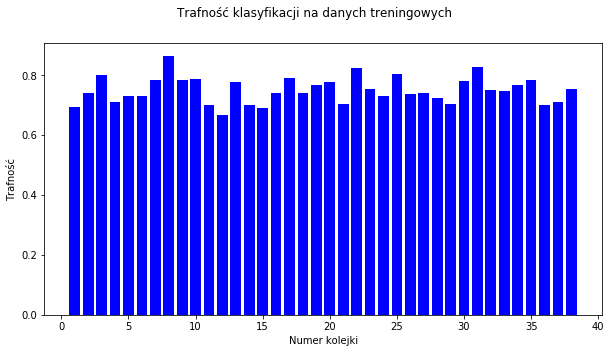

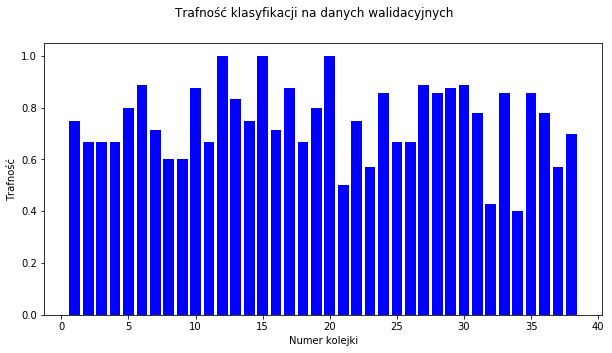

In [228]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(n_estimators=150, subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 80,verbose= False,eval_set= [[X_validation, y_validation]])

weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_copy1[df_copy1.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]

dff = pd.DataFrame(weekly_accuracy)  
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Trafność klasyfikacji na danych treningowych')
plt.xlabel('Numer kolejki')
plt.ylabel('Trafność')
plt.show()
    
weekly_accuracy = {}
for idx in range(1,39):
    df_test1 = df_test[df_test.MW == idx]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']

    weekly_accuracy[idx-1] = [idx,classifier.score(X_validation, y_validation)]
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.suptitle('Trafność klasyfikacji na danych walidacyjnych')
plt.xlabel('Numer kolejki')
plt.ylabel('Trafność')
plt.show()

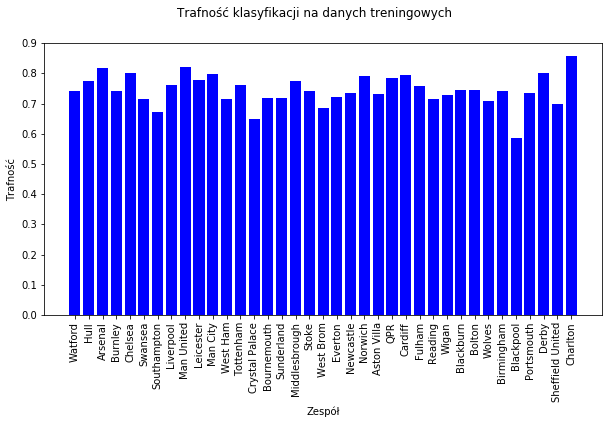

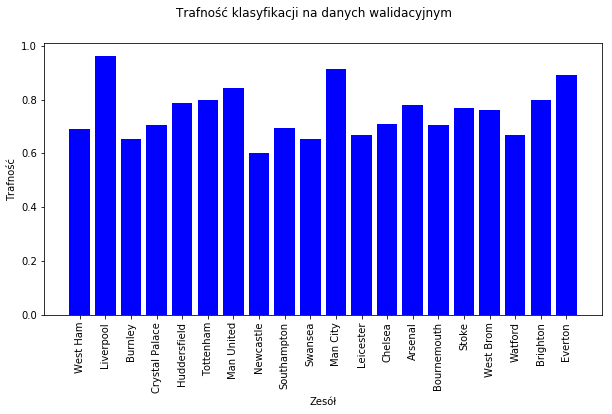

In [298]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]
X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(n_estimators=150, subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 80,verbose= False,eval_set= [[X_validation, y_validation]])

teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_copy1['HomeTeam']):
    df_test1 = df_copy1[(df_copy1.HomeTeam == team) | (df_copy.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
#     if classifier.score(X_validation, y_validation) > 0.75:
    teams_with_high_accuracy.append(team)
    weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
    idx = idx + 1

dff = pd.DataFrame(weekly_accuracy)
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Trafność klasyfikacji na danych treningowych')
plt.xlabel('Zespół')
plt.ylabel('Trafność')
plt.show()

weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
#     if classifier.score(X_validation, y_validation) > 0.75:
    weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
    idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Trafność klasyfikacji na danych walidacyjnym')
plt.xlabel('Zesół')
plt.ylabel('Trafność')
plt.show()

Liverpool 0.9615384615384616
Huddersfield 0.7857142857142857
Tottenham 0.8
Man United 0.84375
Man City 0.9117647058823529
Arsenal 0.78125
Stoke 0.7692307692307693
West Brom 0.76
Brighton 0.8
Everton 0.8928571428571429


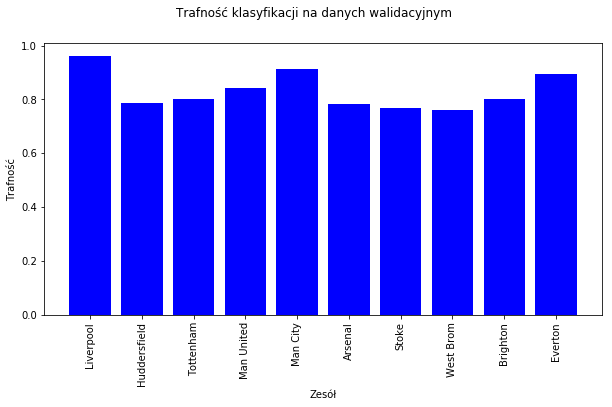

In [300]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

y_train = df_copy.loc[380:]['FTR']
y_validation = df_copy.loc[0:379]['FTR']

df_test = df_copy.loc[0:379]
df_copy1 = df_copy.loc[380:]

X_train = df_copy1[df_copy1.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]
X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(n_estimators=150, subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 80,verbose= False,eval_set= [[X_validation, y_validation]])

teams_with_high_accuracy = []
weekly_accuracy = {}
idx = 0
for team in pd.unique(df_test['HomeTeam']):
    df_test1 = df_test[(df_test.HomeTeam == team) | (df_test.AwayTeam == team)]

    X_validation = df_test1[df_test1.columns.difference(['FTR'])]
    X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
    y_validation = df_test1['FTR']
    
    if classifier.score(X_validation, y_validation) > 0.75:
        teams_with_high_accuracy.append(team)
        weekly_accuracy[idx] = [find_team(team),classifier.score(X_validation, y_validation)]
        print(find_team(team),classifier.score(X_validation, y_validation))
        idx = idx + 1
    
dff = pd.DataFrame(weekly_accuracy)  
plt.bar(dff.loc[0],dff.loc[1],color='blue')
plt.xticks(rotation=90)
plt.suptitle('Trafność klasyfikacji na danych walidacyjnym')
plt.xlabel('Zesół')
plt.ylabel('Trafność')
plt.show()

In [302]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])
df_copy = df_copy[df_copy.MW > 4]
df_copy = df_copy[df_copy.MW < 31]
df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

df_test = df_test[(df_test.HomeTeam.isin(teams_with_high_accuracy)) | (df_test.AwayTeam.isin(teams_with_high_accuracy))]


y_train = df_copy.loc[380:]['FTR']
y_validation = df_test['FTR']

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(n_estimators=150, subsample=0.9930997509655403, gamma= 6, min_child_weight= 0, 
                               colsample_bytree=0.8471293784347718, max_depth= 3,learning_rate=0.03790066341815391,nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 80,verbose= True,eval_set= [[X_validation, y_validation]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-error:0.228188
Will train until validation_0-error hasn't improved in 80 rounds.
[1]	validation_0-error:0.221477
[2]	validation_0-error:0.221477
[3]	validation_0-error:0.221477
[4]	validation_0-error:0.187919
[5]	validation_0-error:0.174497
[6]	validation_0-error:0.181208
[7]	validation_0-error:0.181208
[8]	validation_0-error:0.174497
[9]	validation_0-error:0.174497
[10]	validation_0-error:0.174497
[11]	validation_0-error:0.174497
[12]	validation_0-error:0.174497
[13]	validation_0-error:0.174497
[14]	validation_0-error:0.174497
[15]	validation_0-error:0.174497
[16]	validation_0-error:0.181208
[17]	validation_0-error:0.181208
[18]	validation_0-error:0.181208
[19]	validation_0-error:0.181208
[20]	validation_0-error:0.181208
[21]	validation_0-error:0.181208
[22]	validation_0-error:0.181208
[23]	validation_0-error:0.181208
[24]	validation_0-error:0.181208
[25]	validation_0-error:0.181208
[26]	validation_0-error:0.181208
[27]	validation_0-error:0.174497
[28]	validation_0-er